In [1]:
import cv2
import numpy as np
import roypy
import matplotlib.pyplot as plt

class MyListener(roypy.IDepthDataListener):

    def __init__(self, z_queue, gray_queue, points3D_queue, ConfidenceIndex_queue, Confidence_queue, undistortImage=False):
        super(MyListener, self).__init__()
        self.z_queue = z_queue
        self.gray_queue = gray_queue
        self.points3D_queue = points3D_queue
        self.ConfidenceIndex_queue = ConfidenceIndex_queue
        self.Confidence_queue = Confidence_queue
        self.undistortImage = undistortImage
        self.cameraMatrix = None
        self.distortionCoefficients = None

    def onNewData(self, data):
        zvalues = []
        xvalues = []
        yvalues = []
        grayvalues = []
        points3D = []
        ConfidenceIndexvalues = [] # whether the pixel measured a valid 3D value
        Confidencevalue = []
        for i in range(data.getNumPoints()):
            zvalues.append(data.getZ(i))
            xvalues.append(data.getX(i))
            yvalues.append(data.getY(i))
            grayvalues.append(data.getGrayValue(i))
            
            Confidencevalue.append(data.getDepthConfidence(i))
            if data.getDepthConfidence(i) > 0:
                ConfidenceIndexvalues.append(i)
            
        zarray = np.asarray(zvalues)
        z = zarray.reshape (-1, data.width)        
        self.z_queue.put(z)
        
        xarray = np.asarray(xvalues)
        x = xarray.reshape (-1, data.width)
        
        yarray = np.asarray(yvalues)
        y = yarray.reshape (-1, data.width)
        
        points3D = np.dstack((x,y,z))
        self.points3D_queue.put(points3D)
        
        
        grayarray = np.asarray(grayvalues)
        q = grayarray.reshape (-1, data.width)        
        self.gray_queue.put(q)
        
        Confidencearray = np.asarray(Confidencevalue)
        Confidence = Confidencearray.reshape (-1, data.width)
        self.Confidence_queue.put(Confidence)
        #ConfidenceIndex_queue
        ConfidenceIndex = np.asarray(ConfidenceIndexvalues)
        self.ConfidenceIndex_queue.put(ConfidenceIndex)

    def paint(self, data, name,isGray = False):
        """
        Called in the main thread, with data containing one of the items that was added to the queue in onNewData
        :param data:
        :return:
        """

        # create a figure and show the raw data
        plt.figure(1)
        if isGray == False:
            plt.imshow(data),plt.title(name),plt.axis('off')
        else: 
            plt.imshow(data,plt.cm.gray),plt.title(name),plt.axis('off')

        plt.show(block=False)
        plt.draw()

        # this pause is needed to ensure the drawing for some backends
        plt.pause(0.001)

In [2]:
import argparse
import roypy
import time
import queue
import math
import random
from sample_camera_info import print_camera_info
from roypy_sample_utils import CameraOpener, add_camera_opener_options

In [3]:
# 調整np.array輸出格式
np.set_printoptions(suppress=True)

In [4]:
# def sample_open_cv():
#     #platformhelper = PlatformHelper()
#     parser = argparse.ArgumentParser(usage=__doc__)
#     add_camera_opener_options(parser)
#     parser.add_argument("--seconds", type=int, default=15, help="duration to capture data")
#     options = parser.parse_args(args=['--seconds', '5'])
#     opener = CameraOpener(options)
#     cam = opener.open_camera()

#     z_queue = queue.Queue()
#     gray_queue = queue.Queue()
#     points3D_queue = queue.Queue()
#     l = MyListener(z_queue,gray_queue,points3D_queue)

#     cam.registerDataListener(l)
#     cam.startCapture()

# #     process_event_queue(z_queue, gray_queue, painter=l, seconds=2)
# #     test(points3D_queue, painter=l)
#     process_event(z_queue, gray_queue, points3D_queue, painter=l, seconds=2)
    
#     cam.stopCapture()

In [5]:
def process_event(z_queue, gray_queue, points3D_queue, ConfidenceIndex_queue, Confidence_queue, painter=None, seconds=150):
    # create a loop that will run for the given amount of time
    t_end = time.time() + seconds
    while time.time() < t_end:
        try:
            # try to retrieve an item from the queue
            # this will block until an item can be retrieved
            # or the timeout of 1 second is hit

            zImage = z_queue.get(True) if z_queue else None
            grayImage_int32 = gray_queue.get(True) if gray_queue else None
            points3D = points3D_queue.get(True) if points3D_queue else None
            ConfidenceIndex = ConfidenceIndex_queue.get(True) if ConfidenceIndex_queue else None
        except queue.Empty:
            # this will be thrown when the timeout is hit
            break
            # break
        else:
            painter.paint(zImage,'Depth')
            painter.paint(grayImage_int32,'Gray Image',True)
#             print(points3D.shape,zImage.shape,grayImage.shape)
            #RANSAM to get surface plane
            surface_plane, depthImg, plane_mask = RANSAM(points3D, ConfidenceIndex, ransac_iteration = 500, inliner_threshold = 0.01)
            #Canny edge map(infrared image) + threshold based edge map(depth image)
            Cannyedges, grayImage = get_edge_map(grayImage_int32,depthImg)
            painter.paint(Cannyedges,'Canny Edges',True)
#             painter.paint(plane_mask,'plane_mask',True)
#             painter.paint(depthImg,'depthImg',True)

RANSAM

In [6]:
def get_Plane(sampts):
    p1 = sampts[0]
    p2 = sampts[1]
    p3 = sampts[2]
    
    a = ( (p2[1]-p1[1])*(p3[2]-p1[2])-(p2[2]-p1[2])*(p3[1]-p1[1]) )
 
    b = ( (p2[2]-p1[2])*(p3[0]-p1[0])-(p2[0]-p1[0])*(p3[2]-p1[2]) )
 
    c = ( (p2[0]-p1[0])*(p3[1]-p1[1])-(p2[1]-p1[1])*(p3[0]-p1[0]) )
    
    d = ( 0-(a*p1[0]+b*p1[1]+c*p1[2]) )
    
    return a,b,c,d

# def dis_pt2plane(pt, a, b, c, d):
#     normal = math.sqrt(a*a+b*b+c*c)
#     if normal == 0:
#         normal = 1
    
#     dis = abs(a*pt[0]+b*pt[1]+c*pt[2]+d)/normal
#     return dis

def Dis_pt2plane(pts, a, b, c, d):
    normal = math.sqrt(a*a+b*b+c*c)
    if normal == 0:
        normal = 1
    
    v = np.array([a,b,c])
    dis = abs(np.dot(pts,v.T)+d)/normal
    return dis

def Random3points(points3D, ConfidenceIndex):
    sample_number = 3
    sample_point_index = random.sample(range(ConfidenceIndex.shape[0]), sample_number)
    sample_points = np.zeros((sample_number,3))
    for i in range(sample_number):
        Confidence_point_index = sample_point_index[i]
        index = ConfidenceIndex[Confidence_point_index]
        y = index // points3D.shape[1]
        x = index % points3D.shape[1]
        sample_points[i] = points3D[y][x]
    return sample_points

# def Random3points(points3D):
#     sample_number = 3
#     sample_point_index = random.sample(range(points3D.shape[0]*points3D.shape[1]), sample_number)
#     sample_points = np.zeros((sample_number,3))
#     for i in range(sample_number):
#         index = sample_point_index[i]
#         y = index // points3D.shape[1]
#         x = index % points3D.shape[1]
#         sample_points[i] = points3D[y][x]
#     return sample_points

# def get_inliner_num(points3D,a,b,c,d,inliner_threshold):
#     inliner_num = 0
#     for y in range(points3D.shape[0]):
#         for x in range(points3D.shape[1]):
#             dist = dis_pt2plane(points3D[y,x,:],a,b,c,d)
#             if dist < inliner_threshold:
#                 inliner_num = inliner_num + 1
#     return inliner_num

def get_inliner_num(points3D,a,b,c,d,inliner_threshold):
    inliner_num = 0
    
    dist = Dis_pt2plane(points3D,a,b,c,d)
    inliner_mask = dist < inliner_threshold
    inliner_num = np.sum(inliner_mask)
    return inliner_num, inliner_mask, dist

def RANSAM(points3D, ConfidenceIndex, ransac_iteration = 1000, inliner_threshold = 0.01):
    best_inlinernum = -1
    best_inlinernum = 0
    best_plane = np.zeros((1,4))
    best_depthImage = np.zeros((points3D.shape[0],points3D.shape[1]))
    best_plane_mask = np.zeros((points3D.shape[0],points3D.shape[1]))
#     best_sampts = np.zeros((3,3))
    
#     print(points3D.shape,points3D[80:90,110])
    for i in range(ransac_iteration):
        sampts = Random3points(points3D, ConfidenceIndex)
        a,b,c,d = get_Plane(sampts)
        
        inliner_num, inliner_mask, depthImage = get_inliner_num(points3D,a,b,c,d,inliner_threshold)
        if(inliner_num > best_inlinernum):
            best_inlinernum = inliner_num
            best_plane = np.array([a,b,c,d])
            best_plane_mask = inliner_mask
            best_depthImage = depthImage
#             best_sampts = sampts
            
    print("Inliner Number\n", best_inlinernum)
    print("Inliner plane\n", best_plane)
    return best_plane, best_depthImage, best_plane_mask

# ptset = np.array(([0, 0, 0],
#             [1, 2, 0],
#             [2, 2, 0]))
# a,b,c,d = get_Plane(ptset)
# pts = np.zeros((2,2,3))
# pts[0,0] = np.array([0, 0, 1])
# pts[0,1] = np.array([0, 0, 2])
# pts[1,0] = np.array([0, 0, 3])
# pts[1,1] = np.array([0, 0, 4])
# z = Dis_pt2plane(pts,a,b,c,d)
# print(z,z.shape)
# get_inliner_num(pts,a,b,c,d,7)

Edge map

In [7]:
def get_edge_map(grayImage,depthImage):
    """
    Canny Edge map
    turn grayImg from int32 to int8
    blur the grayImg then do Canny Edge
    """
    low_threshold = 1
    high_threshold = 10
    grayimg_int8 = cv2.convertScaleAbs(grayImage, alpha=(255.0/65535.0))
    
    kernel_size = 3
    blur_gray = cv2.GaussianBlur(grayimg_int8,(kernel_size, kernel_size), 0)
    Cannyedges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    """
    Threshold based Edge map
    
    """
    
    return Cannyedges, blur_gray

In [8]:
# sample_open_cv()

In [9]:
# ptset = np.array(([False, False, False],
#             [True, True, False],
#             [False, True, False]))
# plt.imshow(ptset,plt.cm.gray)
# #True: white   False: black

Main

Number of cameras connected:  1
        Camera information
Type:            PICOFLEXX
Width:           224
Height:          171
Operation modes: 10
    MODE_9_5FPS_2000
    MODE_9_10FPS_1000
    MODE_9_15FPS_700
    MODE_9_25FPS_450
    MODE_5_35FPS_600
    MODE_5_45FPS_500
    MODE_MIXED_30_5
        this operation mode has 2 streams
    MODE_MIXED_50_5
        this operation mode has 2 streams
    Low_Noise_Extended
    Fast_Acquisition
CameraInfo items: 8
    ('BRIDGE_TYPE', 'Enclustra')
    ('MODULE_IDENTIFIER', '00000000')
    ('MODULE_IDENTIFIER_HASH', '558161692')
    ('MODULE_SERIAL', '0')
    ('MODULE_SUFFIX', '')
    ('IMAGER', 'M2450_A12_AIO')
    ('PROCESSING_NAME', 'Spectre')
    ('PROCESSING_VERSION', '3.13.2.773')
isConnected True
getFrameRate 5
200


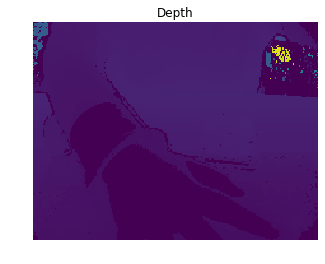

<Figure size 432x288 with 0 Axes>

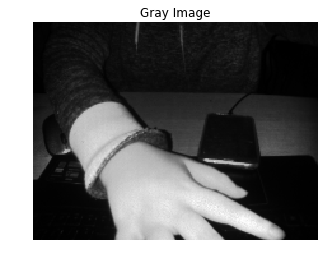

<Figure size 432x288 with 0 Axes>

Inliner Number
 12616
Inliner plane
 [-0.00043284  0.00067252 -0.00007981  0.00000011]


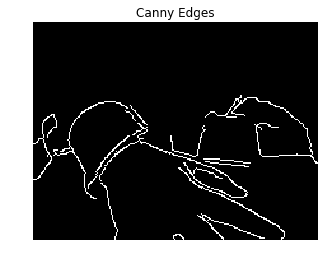

<Figure size 432x288 with 0 Axes>

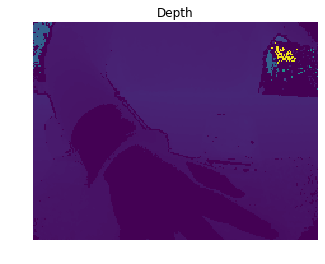

<Figure size 432x288 with 0 Axes>

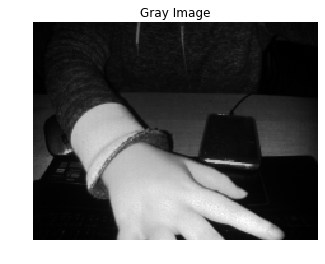

<Figure size 432x288 with 0 Axes>

Inliner Number
 12887
Inliner plane
 [-0.00880963  0.00905177 -0.00000198 -0.00000126]


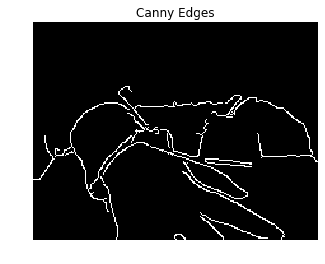

<Figure size 432x288 with 0 Axes>

In [10]:
def main ():
    parser = argparse.ArgumentParser(usage=__doc__)
    add_camera_opener_options(parser)
    parser.add_argument("--seconds", type=int, default=15, help="duration to capture data")
    options = parser.parse_args(args=['--seconds', '5'])
    opener = CameraOpener(options)
    cam = opener.open_camera()

    print_camera_info (cam)
    print("isConnected", cam.isConnected())
    print("getFrameRate", cam.getFrameRate())
    print(cam.getFilterLevel())

    z_queue = queue.Queue()
    gray_queue = queue.Queue()
    points3D_queue = queue.Queue()
    ConfidenceIndex_queue = queue.Queue()
    Confidence_queue = queue.Queue()
    l = MyListener(z_queue,gray_queue,points3D_queue,ConfidenceIndex_queue,Confidence_queue)

    cam.registerDataListener(l)
    cam.startCapture()

    process_event(z_queue, gray_queue, points3D_queue, ConfidenceIndex_queue, Confidence_queue, painter=l, seconds=2)

    cam.stopCapture()
    
    
if (__name__ == "__main__"):
    main()